# Medindo a qualidade da reconstrução de imagens

É desafiador medir a qualidade de uma imagem. Veremos algumas estratégias distintas, mas é importante notar que esse ainda é um problema em aberto.

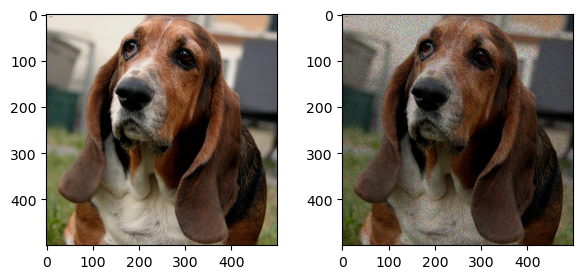

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn

img = np.array(Image.open('../data/basset_hound_53.jpg'))
img = torch.from_numpy(img).float()/255

# Adiciona ruído
noise = torch.rand(img.shape)*0.5 + 0.5
img_noise = img*noise

fig, axs = plt.subplots(1, 2, figsize=(7,3))
axs[0].imshow(img)
axs[1].imshow(img_noise)

Como comparar a similaridade entre as duas imagens acima? Veremos algumas abordagens abaixo.

### Loss functions

Funções básicas para comparar a similaridade são:

In [2]:
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
bce_loss = nn.BCELoss()

print(mse_loss(img_noise, img))
print(l1_loss(img_noise, img))
print(bce_loss(img_noise, img))

tensor(0.0161)
tensor(0.0910)
tensor(0.5456)


Essas funções podem ser usadas para otimizar uma rede neural. O objetivo da rede será minimizar dissimilaridade entre a imagem de entrada e saída de acordo com o critério fornecido. Vamos visualizar o comportamento dessas funções:

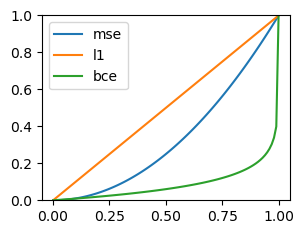

In [3]:
def plot_vals(y):
    """Mostra valores das funções de loss quando o target é dado por `y` e
    o resultado da rede é um valor no intervalo [0,1]."""

    y = torch.tensor(y)

    x = torch.linspace(0, 1, 100)
    mse = (y-x)**2
    l1 = (y-x).abs()
    bce = -(y*torch.log(x+1e-5)+(1-y)*torch.log(1-x+1e-5))

    bce -= bce.min()

    mse /= mse.max()
    l1 /= l1.max()
    bce /= bce.max()

    plt.plot(x, mse, label='mse')
    plt.plot(x, l1, label='l1')
    plt.plot(x, bce, label='bce')
    plt.ylim((0,1))
    plt.legend()

plot_vals(0.)

A loss BCE tende a dar maior penalização para pixeis muito incorretos. Ela ajuda a garantir que não haverá erros muito notáveis no resultado. Mas pode ocorrer da imagem nunca ficar "muito boa", pois basta os pixeis terem valores similares para essa loss ter um valor baixo.

A loss l1 não dá a penalização extra para pixeis muito ruins, mas ela ajuda a garantir que boa parte dos pixeis serão bem parecidos entre as duas imagens. 

A loss MSE é um meior termo entre as duas.

É muito comum a loss MSE ser utilizada em autoencoders. Mas para os nossos objetivos verifiquei que a loss l1 deu resultados melhores, então iremos utilizar ela.

### Fréchet Inception Distance

A medida de similaridade estado da arte atualmente utiliza especificamente o modelo Inception V3 para extrair atributos das imagens. Os atributos são então comparados.

In [4]:
from torchvision.models import inception_v3, Inception_V3_Weights

def get_model():

    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    model.eval()
    # Remoção da camada de classificação
    model.fc = nn.Identity()

    return model

def get_features(model, img):

    batch = img.permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        features = model(batch).squeeze()

    return features.squeeze()

model = get_model()
features = get_features(model, img).shape
print(features)

torch.Size([2048])


O modelo extrai 2048 características das imagens. O medida Fréchet Inception Distance compara a distribuição dessas características para dois datasets (o original e o recuperado pela rede). Mas como temos apenas uma imagem, compararemos diretamente as características.

In [5]:
def frechet_inception_distance(input, target):

    model = get_model()
    feat_inp = get_features(model, input)
    feat_tar = get_features(model, target)

    sim = torch.sum((feat_inp-feat_tar)**2)

    return sim

sim = frechet_inception_distance(img_noise, img)
print(sim)

tensor(11.5095)


### Inspeção visual

Também podemos verificar a qualidade do resultado através da inspeção visual, ou seja, olhando para as imagens. Implementaremos uma forma de visualizar os resultados durante o treinamento da rede.

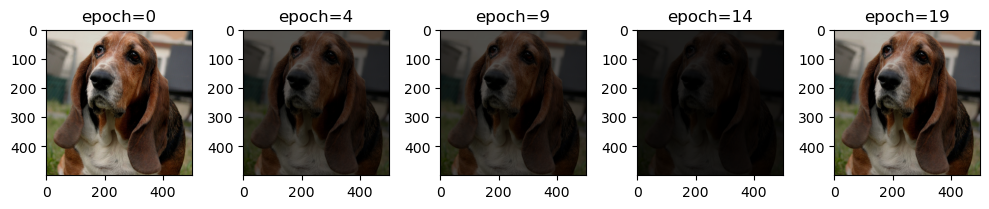

In [7]:
import time
from IPython import display

def show_imgs(logger, n=5):
    """Dada uma lista de imagens, mostra n imagens selecionadas de forma
    igualmente espaçadas desta lista."""

    epochs, imgs = zip(*logger)
    epochs = list(epochs)
    imgs = list(imgs)

    # Cria uma lista de n índices igualmente espaçados entre 0 e len(imgs)
    inds = torch.linspace(0, len(imgs)-1, n)
    inds = inds.int()
    # Corta lista de índices caso len(img)<n
    inds = inds[:len(imgs)]

    fig, axs = plt.subplots(1, n, figsize=(10,2))
    # Mostra as imagens
    for i, ind in enumerate(inds):
        axs[i].imshow(imgs[ind])
        axs[i].set_title(f"epoch={epochs[ind]}")

    fig.tight_layout()

    display.clear_output(wait=True) 
    plt.show()

# Simulação de um loop de treinamento
logger = []
for epoch in range(20):
    # Aqui a rede seria treinada e validada. Criamos uma imagem
    # aleatórioa só para exemplificar
    img_rec = img*torch.rand(1)
    time.sleep(0.5)
    #-----------------------------------------
    # Adiciona imagem ao log
    logger.append((epoch, img_rec))
    # Mostra algumas imagens do log
    show_imgs(logger)